# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

In [9]:
J(f1)(0.,0.)

array([0., 0.])

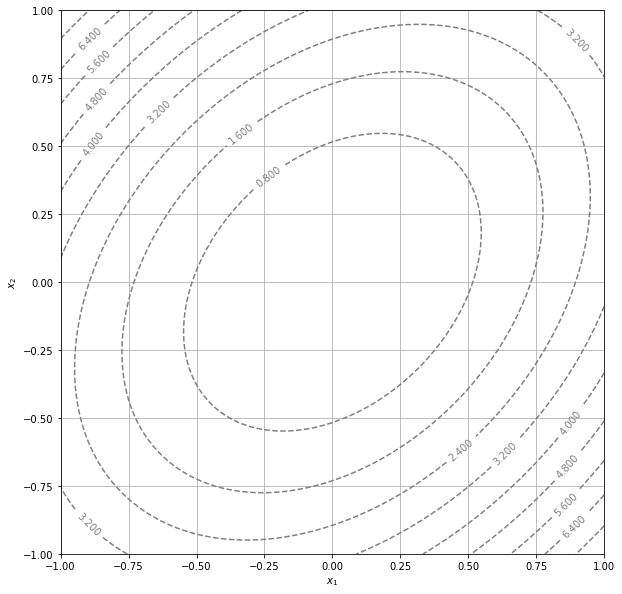

In [10]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [11]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

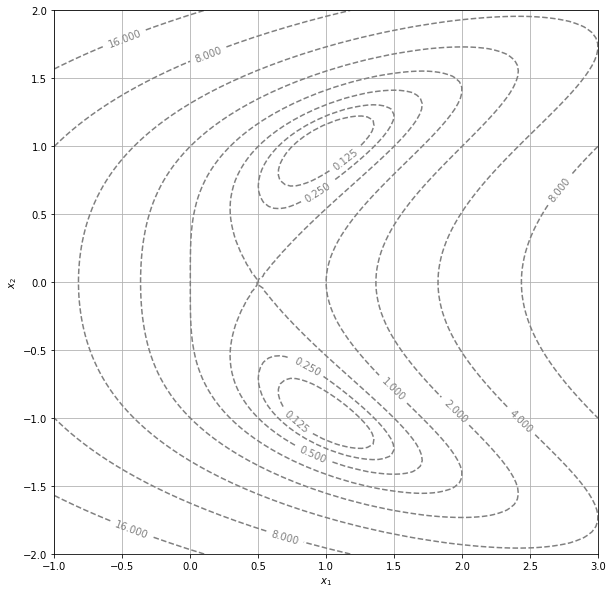

In [12]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [13]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

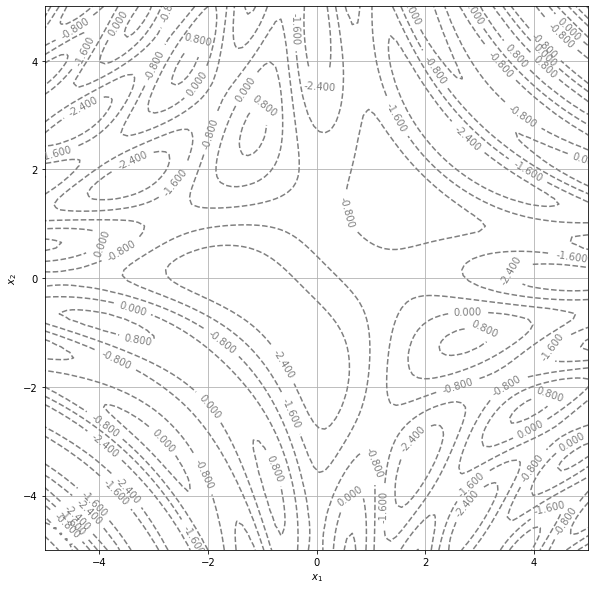

In [14]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

**Réponse**
- f est continue et $\{c\}$ est un fermé donc $f^{-1}(c)$ est un fermé
- Par définition de la limite, il existe $M\geq0$ tel que, pour tout $(x_{1},x_{2})\in\mathbb{R^{2}}$, si $\|(x_{1},x_{2})\|\geq M$, alors $f(x_{1},x_{2})\geq c+1$. Ainsi, si $x\in f^{-1}(c)$, alors $\|x\|<M$. Par conséquent, $f^{-1}(c)$ est borné

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

**Réponse :**

On définit $v := \frac{\nabla f(x_0)}{\| \nabla f(x_0) \|}   $

On définit aussi $u :=\begin{pmatrix}
0 & 1 \\
-1 & 0
\end{pmatrix} v = \frac{1}{\| \nabla f(x_0) \|}
\begin{pmatrix}
\partial_2 f(x_0) \\
-\partial_1 f(x_0)
\end{pmatrix}$ un vecteur unitaire orthogonal à $v$. $(u,v)$ est donc une base orthogonale de $\mathbb{R}^{2}$, que l'on fait même repère avec le point $x_0$

$p(x_1,x_2) = \langle u,
\begin{pmatrix}
x_1 - x_{10} \\
x_2 - x_{20}
\end{pmatrix}
\rangle
$
est donc la coordonée de $x$ selon $u$ dans le repère $(u,v,x_0)$

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

**Réponse**

$f$ est continûment différentiable, donc il existe un voisinage $W \subset \mathbb{R}^2$ de $x_0$ tel que $\forall x \in W$ , $\| \nabla f(x) \| \neq 0$
On définit $$ g : \Bigg  \{ \begin{array}{ccc} W \times \mathbb{R} \longrightarrow \mathbb{R}^2 \\ (x_1,x_2) \longrightarrow x 
\begin{pmatrix}
f(x_1,x_2)-c \\
-p(x_1,x_2)+t
\end{pmatrix}
\end{array} $$
On a alors : 
$\partial_x g(x,t) = 
    \begin{pmatrix} 
    \partial_1 f(x) & \partial_2 f(x) \\
    -\partial_1 p(x) & -\partial_2 p(x)
    \end{pmatrix}  = 
    \begin{pmatrix}
    \partial_1 f(x) & \partial_2 f(x) \\
    -\partial_1 f(x) & \partial_2 f(x)
    \end{pmatrix} 
$.
Comme $f$ est continûment différentiable, $\partial_x g$ est continue. De plus,
$$ \forall (x,t) \in W \times \mathbb{R} , det(\partial_x g(x,t)) = \| \nabla f(x) \|^2 $$
Donc $\partial_x g(x)$ est inversible pour tout $ x \subset W \times \mathbb{R} $.
$ \partial_t g(x,t) = 
   \begin{pmatrix}
   0 \\
   1
   \end{pmatrix} 
$ donc $\partial_t g $ est continue. g est donc continûment différentiable. Le théorème des fonctions implicites assure alors que 
$$ \exists (U,V) \subset W \times \mathbb{R}, \exists ! \gamma : V \subset \mathbb{R} \longrightarrow \mathbb{R}^2 $$
tels que : 
 - $U$ et $V$ sont ouverts
 - $\gamma$ est continûment différentiable
 - $ g(x,t) = 0 \Longleftrightarrow x = \gamma(t) $

Or, en considérant $t=p(x_1,x_2)$, $f(x)=c \Longleftrightarrow g(x_1,x_2,t) = 0$ par définition de g.
Ainsi, on a :
$$ f(x) = c \Longleftrightarrow \gamma(p(x_1,x_2))=0 $$
Cette relation est valable sur un voisinage de 0, donc il existe $\epsilon >0$ tel que cette dernière est vraie sur $]-\epsilon,\epsilon[$

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

**Réponse**

- $id_{\mathbb{R}^2} = p\circ \gamma $ donc $\forall t \in ]-\epsilon,\epsilon[, 1 = dp(x)\circ\gamma '(t)$ . Comme $dp(x)$ est linéaire, $\forall t \in ]-\epsilon,\epsilon[, \gamma '(t) \neq 0 $
- $\forall t \in ]-\epsilon,\epsilon[, f(\gamma(t)) = c$. En dérivant, on obtient : $\langle \nabla f(\gamma (t)), \gamma '(t) \rangle = 0$. Donc pour tout $t\in ]-\epsilon,\epsilon[, \gamma '(t)$ est orthogonal à $\nabla f(\gamma (t))$

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

Une cellule

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [15]:
N = 100
eps = 0.005


**Réponse**

L'approximation doit être précise puisque l'on se place déjà dans un voisinage (généralement petit) de $(x, y)$, 
il faut donc que $\epsilon$ soit au moins un ordre de grandeurs plus bas que la taille du voisinage.
Toutefois, pour que la fonction Newton n'aie pas à terminer ses N tours, il est préférable de ne pas choisir un $\epsilon$ trop faible.
Dans les exemples ci-dessous, on utilisera des voisinages de l'ordre de 0.1 à 0.01, nous hoisissons donc $\epsilon$ = 0.005

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [16]:
def Newton(F, x0, y0, eps=eps, N=N):
    J_F = J(F)
    for i in range(N):
        JFxy = J_F(x0,y0) 
        if np.linalg.det(JFxy) != 0 :
            D = np.linalg.inv(JFxy).dot(np.array(F(x0,y0)))
            x = x0 - D[0]
            y = y0 - D[1]
        else :
            raise ValueError("Singular jacobian")
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps  :
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [17]:
def F(x1,x2) :
    x1 = np.array(x1)
    x2 = np.array(x2)
    y1 = f1(x1,x2) - 0.8
    y2 = x2 - x1
    return np.array([y1,y2])

In [18]:
Newton(F,0.8,0.8)

(0.4472135970019964, 0.4472135970019964)

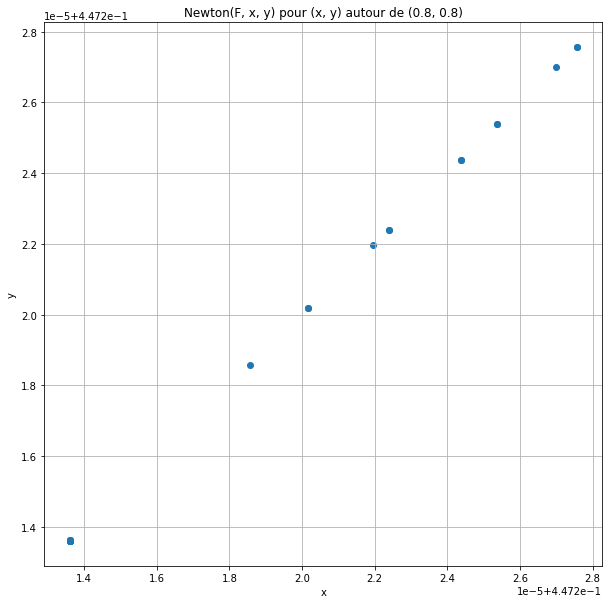

In [19]:
X = np.linspace(0.7, 0.9, 10)    # On fait varier le point initial
Y = np.linspace(0.7, 0.9, 10)
X2 = []
Y2 = []
for x in X:
    for y in Y:
        a = Newton(F, x, y)
        X2.append(a[0])
        Y2.append(a[1])

plt.title('Newton(F, x, y) pour (x, y) autour de (0.8, 0.8)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.scatter(X2, Y2)
plt.show()

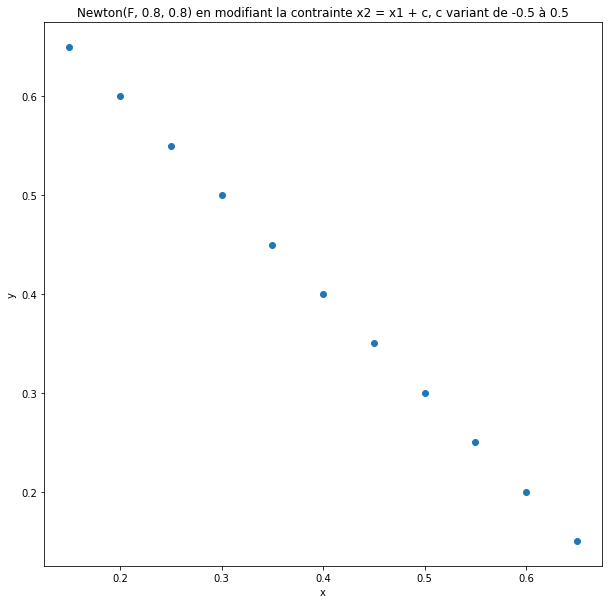

In [20]:
contrainte = np.linspace(-0.5,0.5,11)
X3 = []
Y3 = []


for c in contrainte :
    
    def F(x1,x2) :
        x1 = np.array(x1)
        x2 = np.array(x2)
        y1 = f1(x1,x2)
        y2 = x2 - x1 - c
        return np.array([y1,y2])
    
    a = Newton(F, 0.8, 0.8, x)
    X3.append(a[0])
    Y3.append(a[1])

plt.title('Newton(F, 0.8, 0.8) en modifiant la contrainte x2 = x1 + c, c variant de -0.5 à 0.5')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X3, Y3)
plt.show()

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

**Réponse**

Premièrement, essayons de placer approximativement le point $(x_1, y_1)$ situé à une distance $\delta$ de $(x_0, y_0)$ à droite lorsque l'on regarde dans la direction de $\nabla f(x_0, y_0)$
$$  
    u := \delta 
    \begin{pmatrix}
    0 & 1 \\
    -1 & 0
    \end{pmatrix} 
    \frac{\nabla f(x_0, y_0)}{\| \nabla f(x_0, y_0) \|} 
$$
Comme $\nabla f(x_0, y_0)$ est multipliée à gauche par une matrice de rotation dont l'angle de rotation est $-90°$, ce vecteur est bel et bien orienté tel qu'on le souhaitait. Le facteur $\delta$ fait de $u$ un vecteur de norme $\delta$ (car le reste de l'expression est le produit d'un vecteur unitaire par une matrice orthogonale), ainsi, le point $(x_0 + u_0, y_0 + u_1)$ est situé à proximité du point $(x_1, y_1)$ recherché.
$$
    F(x, y) := 
    \begin{pmatrix}
    f(x, y) - c \\
    (x - x_0)^2 + (y - y_0)^2 - \delta^2
    \end{pmatrix}
$$
On cherche alors à annuler $F$, de sorte que :
 - $f(x, y) = c$
 - $(x, y)$ soit à une distance $\delta$ de $(x_0, y_0)$

On cherche ce point $(x_1, y_1)$ avec la méthode de Newton appliquée à $F$ en $(x_0 + u_0, y_0 + u_1)$.

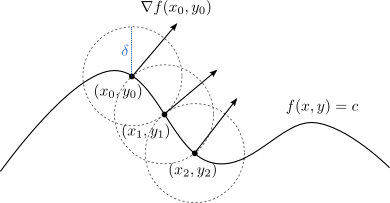

In [21]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    c = f(x0,y0)
    t = np.zeros(shape = (2,N),dtype="float64")
    t[:,0] = [x0,y0]
    
    for n in range(1,N) :  
        g = grad(f)(x0,y0)
        ng = np.linalg.norm(g)
        u = delta*np.array([[0,1],[-1,0]]).dot(g)/ng
        
        def F(x,y) :
            x = np.array(x)
            y = np.array(y)
            z1 = f(x,y) - c
            z2 = np.square(x-x0) + np.square(y-y0) - delta**2
            return np.array([z1,z2])
        
        x0 , y0 = Newton(F,x0+u[0],y0+u[1])
        t[:,n] = [x0,y0]
    return t

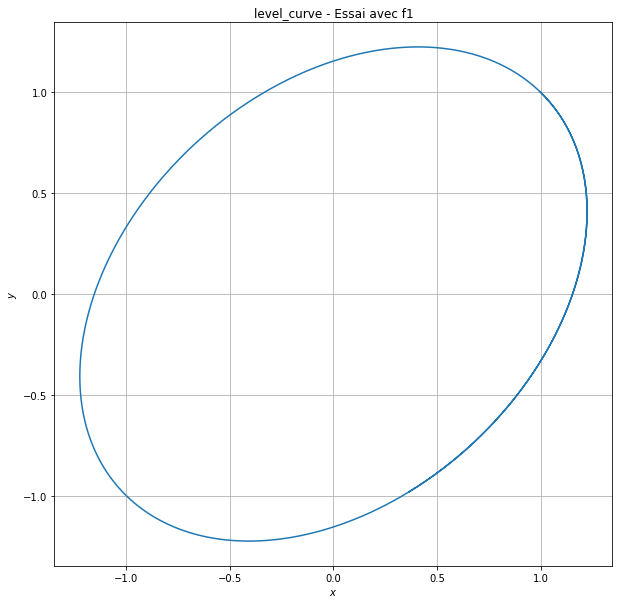

In [22]:
T = level_curve(f1,1.,1.,delta=0.01)
plt.title("level_curve - Essai avec f1")
plt.grid(True)
plt.xlabel("$x$") 
plt.ylabel("$y$")
plt.plot(T[0],T[1])

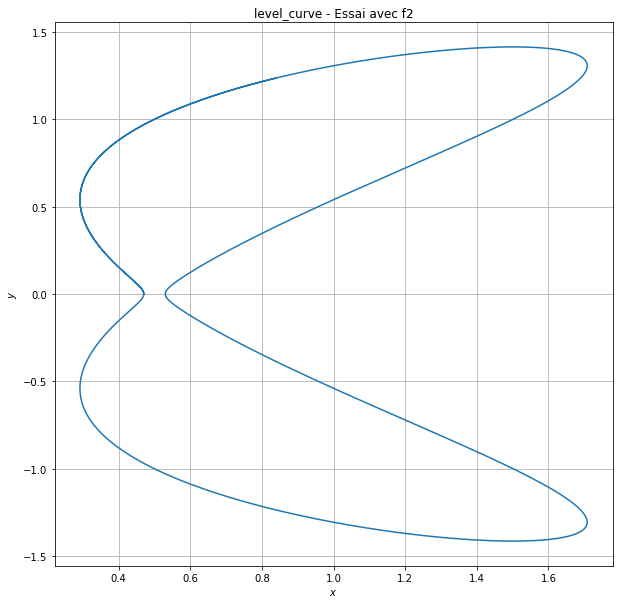

In [23]:
T = level_curve(f2,0.47,0.,delta=0.01)
plt.title("level_curve - Essai avec f2")
plt.grid(True)
plt.xlabel("$x$") 
plt.ylabel("$y$")
plt.plot(T[0],T[1])

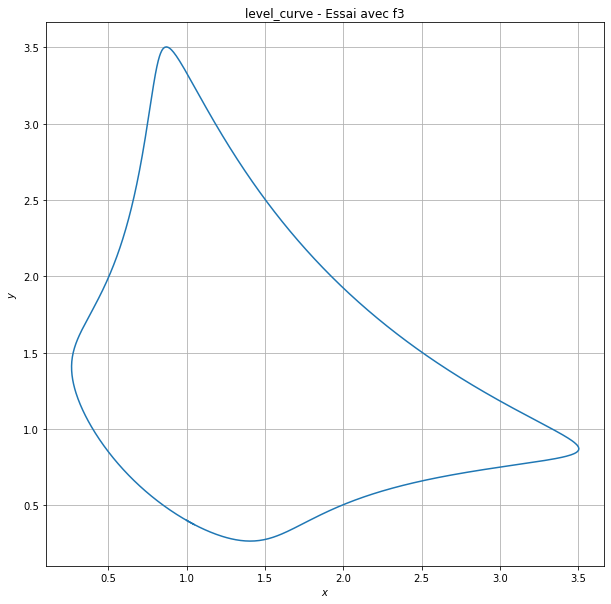

In [24]:
T = level_curve(f3,1.,0.4,delta=0.01)
plt.title("level_curve - Essai avec f3")
plt.grid(True)
plt.xlabel("$x$") 
plt.ylabel("$y$")
plt.plot(T[0],T[1])

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

**Réponse Question 7**

Les courbes similaires à celle de la fonction de Rosenbrock sont les fonctions de la forme :
$$ f(x_1, x_2) = (a - x_1)^2 + b(x_1 - x_2^2)^2 $$
Où a et b sont réels : la page [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function) fournie plus haut avec la définition de $f_2$ nous l'assure. 
Une condition nécessaire à l'auto-intersection d'une courbe de niveau est que le point de croisement soit un extremum local pour chacune des variables. En effet, il faut pouvoir faire décroître $f(x_1, . )$ pendant que $f( . , x_2)$ croît en faisant varier $x_1$ et $x_2$ dans n'importe quelle direction (c'est à dire en faisant croître les deux, décroître les deux ou en faisant croître l'un et pas l'autre). Cette raison explique aussi le fait que l'extremum en question ne peut pas être un extremum global.
$$ \partial_1 f(x_1, x_2) = 2(x_1 - a) +2b(x_1 - x_2^2) $$
$$ \partial_2 f(x_1, x_2) = 4b(x_2^3 -x_1x_2) $$
Si $ \partial_2 f(x_1, x_2) = 0 $, alors $x_2 = 0 $ ou $ x_2^2 = x_1 $. Or, $ \partial_1 f(x_1, x_1^2) = 2(x_1 - a)$. Un extremum est alors $(a, \sqrt(| a |))$ ou encore $(a, -\sqrt(| a |))$. Mais il est clair que ces points d'annulation de $f$, qui est une fonction positive, sont des extrema globaux et ne nous interessent donc pas. 
$$ \partial_1 f(x_1, 0) = 2x_1(1 + b) - 2a $$
Évacuons tout de suite le cas $b = -1$, qui nous obligerais à avoir $a = 0$ pour annuler $\partial_1 f(x_1, 0)$, ce qui revient à avoir $\partial_1 f(x_1, 0)$ toujours nulle : on ne risque pas de faire croître ou décroître $f$ par une action sur $x_1$, donc aucune chance de rééquilibrer l'évolution de $f$ causée par une variation de $x_2$. À présent, si $b \neq -1$ :
$$ \partial_1 f(x_1, 0) = 0 \Longleftrightarrow x_1 = \frac{a}{1 + b} $$
Ainsi, il n'y a qu'une seule seule courbe de niveau par fonction similaire à une fonction de Rosenbrock qui est susceptible de s'auto-intersecter. 


Ainsi, c'est quasiment toujours le premier segment créé qui sera le premier segment intersecté, on peut donc se permettre de netester que l'intersection du dernier segment avec le premier segment créé.

**Explication de la nouvelle fontion level_curve**

On considère deux segments $[u:=(x_0, y_0),v:=(x_1, y_1)]$ et $[w:=(x_2, y_2),z:=(x_3, y_3)]$ que l'on peut paramétrer par $t$ et $r$ : $[u:=(x_0, y_0),v:=(x_1, y_1)] = \{u + t(v - u) , t \in [0, 1]\}$ et $[w:=(x_2, y_2),z:=(x_3, y_3)] = \{w + r(z - w) , r \in [0, 1]\}$. 
Les segments s'intersectent si et seulement si il existe une valeur de $t$ et $r$ tel que :
  - $t(x_1 - x_0) - r(x_2 - x_3) = x_2 - x_0$
  - $t(y_1 - y_0) - r(y_2 - y_3) = y_2 - y_0$

Matrciellement, cela s'écrit :
$$ 
  \begin{pmatrix}
    x_1 - x_0 & x_3 - x_2 \\
    y_1 - y_0 & y_3 - y_2
  \end{pmatrix}
  \begin{pmatrix}
    t \\
    r 
  \end{pmatrix}
  = 
  \begin{pmatrix}
    x_2 - x_0 \\
    y_2 - y_0
  \end{pmatrix}
$$
On obtient r et t en multipliant par l'inverse de la matrice de gauche. Si ces deux nombres sont compris entre 0 et 1, les segments s'intersectent bien.

In [25]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps): #la fonction retourne aussi le nombre de points qu'elle a calculé
    c = f(x0,y0)
    t = np.zeros(shape = (2,N),dtype="float64")
    t[:,0] = [x0,y0]
    
    for n in range(1,N) :  
        g = grad(f)(x0,y0)
        ng = np.linalg.norm(g)
        u = delta*np.array([[0,1],[-1,0]]).dot(g)/ng
        
        def F(x,y) :
            x = np.array(x)
            y = np.array(y)
            z1 = f(x,y) - c
            z2 = np.square(x-x0) + np.square(y-y0) - delta**2
            return np.array([z1,z2])
        
        x0 , y0 = Newton(F,x0+u[0],y0+u[1])
        t[:,n] = [x0,y0]

        if n > 2 :
            u = t[:,1] - t[:,0]
            v = t[:,n] - t[:,n-1]
            A = np.array([u,-v]).T
            if np.linalg.det(A) != 0 :
                s = np.linalg.inv(A).dot(t[:,n-1]-t[:,0]) # s = [t,r]
                if 0 <= s[0] <= 1 and 0 <= s[1] <= 1 :
                    return t[:,:(n+1)] , n       
    return t , n

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

Le tracé s'arrète après 23 étapes


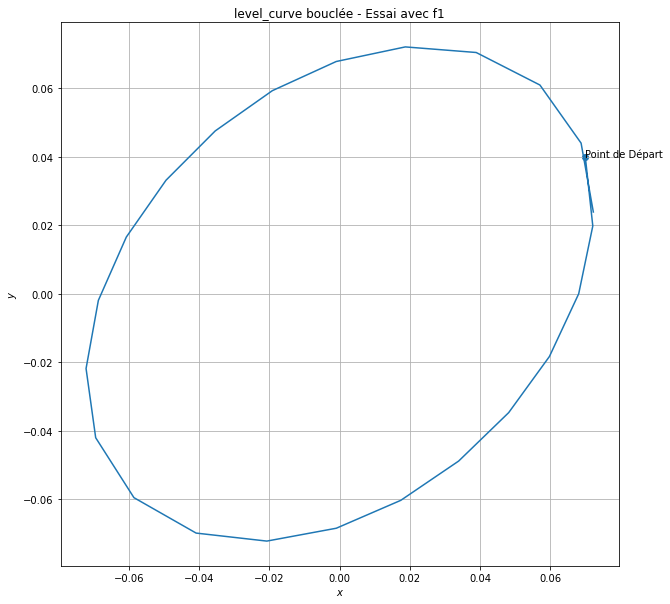

In [26]:
T , n = level_curve(f1,0.07,0.04,N=2000,delta=0.02)
print(f"Le tracé s'arrète après {n} étapes")
plt.title("level_curve bouclée - Essai avec f1")
plt.grid(True)
plt.xlabel("$x$") 
plt.ylabel("$y$")
plt.plot(T[0],T[1])
plt.scatter(0.07,0.04)
plt.text(0.07,0.04,"Point de Départ")
plt.show()

Le tracé s'arrète après 37 étapes


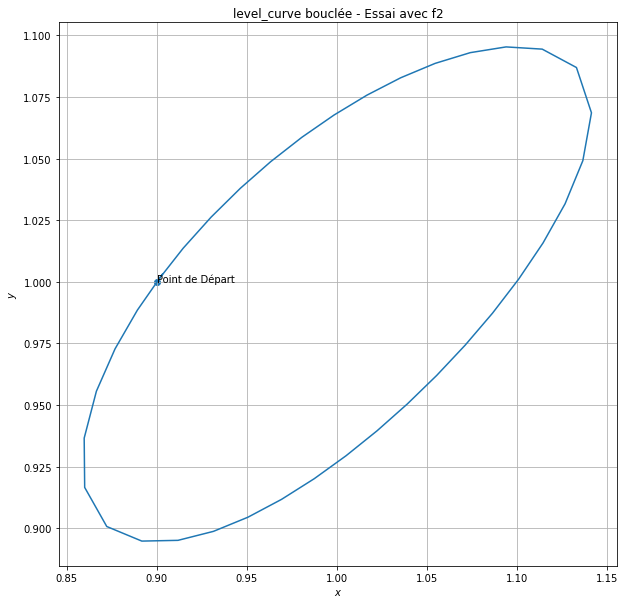

In [27]:
T , n = level_curve(f2,0.9,1.,N=2000,delta=0.02)
print(f"Le tracé s'arrète après {n} étapes")
plt.title("level_curve bouclée - Essai avec f2")
plt.grid(True)
plt.xlabel("$x$") 
plt.ylabel("$y$")
plt.plot(T[0],T[1])
plt.scatter(0.9,1.)
plt.text(0.9,1.,"Point de Départ")
plt.show()

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

** Réponse **

On note $P_1 = (x_1, y_1)$, $P_2 = (x_2, y_2)$, $u_1 = (v_1, w_1)$ et $u_2 = (v_2, w_2)$.
Traduisons les contraintes de l'énoncé en équations :
 - $\gamma(0) = P_1$ donc $a = x_1$ et $d = y_1$
 - $\gamma(1) = P_2$ donc $a + b + c = x_2$ et $d + e + f = y_2$
 - $\gamma'(0)$ est dans la même direction et le même sens que $u_1$ donc $\exists \lambda \geq 0, b = \lambda v_1$ et $e = \lambda w_1$
 - $\gamma'(1)$ est dans la même direction et le même sens que $u_2$ donc $\exists \mu \geq 0, b + 2c = \mu v_2$ et $e + 2f = \mu w_2$

** Détermination des coefficients **

On note désormais matriciellement $\gamma(t) = A + tB + t^2C$. On a bien sûr $A = P_1$ grâce à la condition sur $\gamma(0)$. De plus, $A + B + C = P_2$ donc $C = P_2 - P_1 - B$. Ce qui débouche sur la forme générale : $$ \gamma(t) = P_1 + tB + t^2(P_2 - P_1 - B) $$

Or,  $B = \gamma'(0) = \lambda u_1$

On a donc : $$ \gamma(t) = P_1 + \lambda tu_1 + t^2(P_2 - P_1 - \lambda u_1) $$

**Détermination de la condition d'existence d'une solution**

De plus, $\mu u_2 = \gamma'(1) = B + 2(P_2 - P_1 - B) = 2(P_2 - P_1) - \lambda u_1$. Donc $\lambda u_1 + \mu u_2 = 2(P_2 - P_1)$, c'est à dire :
$$
    \begin{pmatrix}
    v_1 & v_2 \\
    w_1 & w_2
    \end{pmatrix}
    \begin{pmatrix}
    \lambda \\
    \mu
    \end{pmatrix}
    = 2
    \begin{pmatrix}
    x_2 - x_1 \\
    y_2 - y_1
    \end{pmatrix}
$$
1. Si $u_1$ et $u_2$ ne sont pas colinéaires :
    Une solution unique de $\lambda$ et $\mu$ existe et il faut que ces derniers soient positifs, il faut donc que 
    $$ 
        0 \leq
        \frac{2}{v_1 w_2 - w_1 v_2}
        \begin{pmatrix}
        w_2 & -v_2 \\
        -w_1 & v_1
        \end{pmatrix}
        \begin{pmatrix}
        x_2 - x_1 \\
        y_2 - y_1
        \end{pmatrix}
    $$
    Pour exprimer cette condition en fonction de $u_1, u_2, P_1, P_2$ comme l'énoncé le demande, on a : 
    $$ (u_1 | u_2)^{-1}(P_2 -P_1) \geq 0 $$
2. Si $u_1$ et $u_2$ sont colinéaires :
  - Si $P_2 = P_1$ , la solution est triviale. Dans la suite, on considèrera que $P_1$ et $P_2$ sont distincts.
  - Comme $P_2 - P_1 = \lambda u_1 + \mu u_2$, on en déduit que $P_2 - P_1$ est colinéarie à $u_1$ et $u_2$.
  - $u_1$ et $u_2$ ne peuvent pas être tous les deux non nuls et de sens opposé à $P_2 - P_1$, sinon, la courbe représentative de $\gamma$ devrait faire deux demi-tours, ce qui est impossible pour une fonction quadratique.
  - Si $u_1$, $u_2$ et $P_1 - P_2$ sont de même sens, $\gamma(t) = P_1 + t(P_2 - P_1)$ convient.
  - Si $u_2$ est de même sens que $P_2 - P_1$ mais pas que $u_1$, on peut choisir $\gamma(t) = P_1 + t^2(P_2 - P_1)$. On a alors $\lambda = 0$ et $\mu > 0$
  - Si $u_1$ est de même sens que $P_2 - P_1$ mais pas que $u_2$, on peut choisir $\gamma(t) = P_1 +2t(P_2 - P_1) - t^2(P_2 - P_1)$. On a donc $\lambda > 0$ et $\mu = 0$
  - Dans tous les cas, l'une des solutions quadratiques possibles produit un chemin tracé équivalent à l'interpolation linéaire. Comme il nous est impossible de trancher entre les différentes solutions, on privilégie cette dernière.

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [28]:
def gamma(t,P1,P2,u1,u2) :
    P1 = np.array(P1)
    P2 = np.array(P2)
    U = np.array([u1,u2]).T
    P = P2 - P1
    
    if np.linalg.det(U) != 0 :
        l, m = 2*np.linalg.inv(U).dot(P)
        if l >= 0 and m >= 0 :
            """interpolation quadratique"""
            B = l*np.array(u1)
            C = P-B    
            return P1.reshape(2,1) + np.outer(B,t) + np.outer(C,np.square(t))
    else :
        """interpolation linéaire"""
        np.outer(P,t)
        return P1.reshape(2,1) + np.outer(P,t)

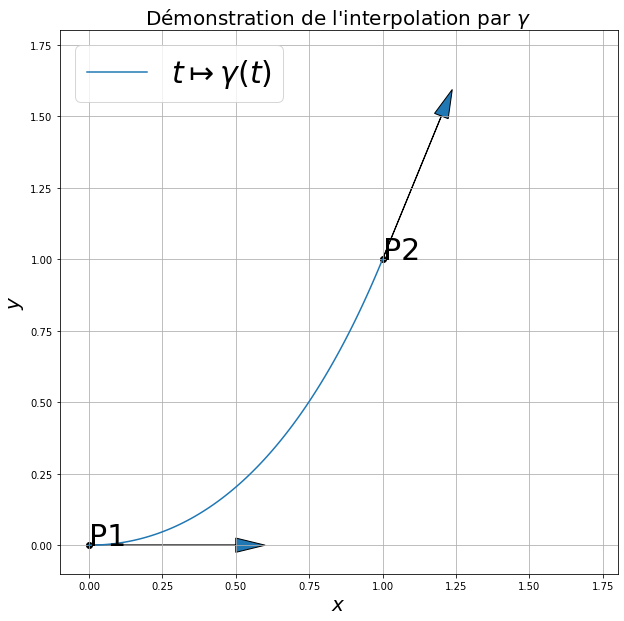

In [29]:
P1 = (0,0)
P2 = (1,1)
u1 = (0.5,0)
u2 = (0.2,0.5)
t = np.linspace(0.,1.,100)
gt = gamma(t,P1,P2,u1,u2)

plt.grid(True)
plt.title("Démonstration de l'interpolation par $\gamma$", fontsize = 20)
plt.xlabel("$x$",fontsize=20) 
plt.ylabel("$y$",fontsize=20)
plt.plot(gt[0],gt[1],label = "$t\mapsto\gamma(t)$")
for i, p in enumerate([P1,P2]) :
    plt.scatter(p[0],p[1],c = "black")
    plt.text(p[0],p[1],f"P{i+1}",fontsize = 30)
plt.arrow(P1[0], P1[1], u1[0], u1[1], head_width=0.05, head_length=0.1)
plt.arrow(P2[0], P2[1], u2[0], u2[1], head_width=0.05, head_length=0.1)
plt.xlim(-0.1,1.8)
plt.ylim(-0.1,1.8)
plt.legend(fontsize = 30)
plt.show()

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [30]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps, oversampling=1):
    c = f(x0,y0)
    t = np.zeros(shape = (2, (N-1)*oversampling+1), dtype="float64")
    t[:,0] = [x0,y0]
    n = 1
    x, y = x0, y0
    
    while True :
        
        g = grad(f)(x,y)
        ng = np.linalg.norm(g)
        u = delta*np.array([[0,1],[-1,0]]).dot(g)/ng
        
        if n > 1 :
            """
            On ajoute la section précédente après avoir calculé le nouveau u
            """
            gt = gamma(np.linspace(0.0,1.0,oversampling+1)[1:],(x0,y0),(x,y),u0,u)
            t[:,(n-2)*oversampling+1:(n-1)*oversampling+1] = gt
            x0, y0 = x, y
            
        if n >= N :
            break
        
        if n > 3 :
            """
            On teste si la première et la dernière section s'intersectent,
            sans prendre en compte la modification du tracé par l'interpolation.
            """
            u1 = t[:,oversampling] - t[:,0]
            u2 = t[:,(n-1)*oversampling] - t[:,(n-2)*oversampling]
            A = np.array([u1,-u2]).T
            if np.linalg.det(A) != 0 :
                s = np.linalg.inv(A).dot(t[:,(n-2)*oversampling]-t[:,0])
                if 0 <= s[0] <= 1 and 0 <= s[1] <= 1 :
                    return t[:,:((n-1)*oversampling+1)]  
            
        def F(x,y) :
            x = np.array(x)
            y = np.array(y)
            z1 = f(x,y) - c
            z2 = np.square(x-x0) + np.square(y-y0) - delta**2
            return np.array([z1,z2])
        
        u0 = u.copy()
        x , y = Newton(F,x0+u[0],y0+u[1])
        
        n += 1
    
    return t

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

C:\Users\Max\miniconda3\lib\site-packages\numpy\linalg\linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\Max\miniconda3\lib\site-packages\numpy\linalg\linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


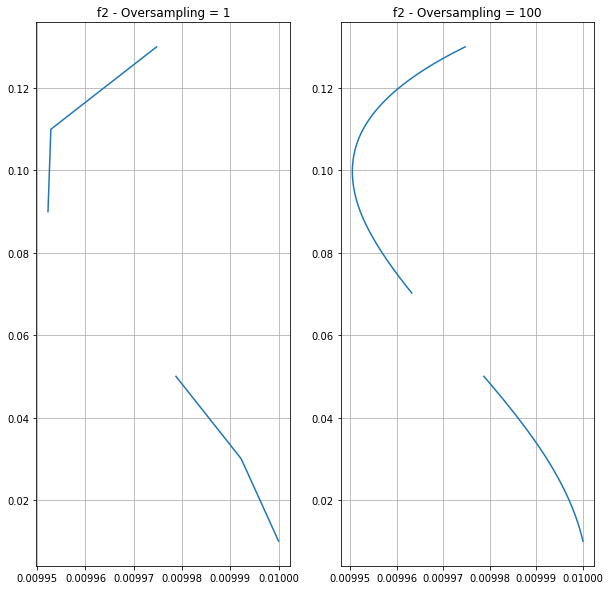

In [31]:
fig = plt.figure()
sans_os = plt.subplot(1,2,1)
sans_os.set_title('f2 - Oversampling = 1')
avec_os = plt.subplot(1,2,2)
avec_os.set_title('f2 - Oversampling = 100')

T = level_curve(f2,0.01,0.01,N=7,delta=0.02)
sans_os.grid(True)
sans_os.plot(T[0],T[1])

T = level_curve(f2,0.01,0.01,N=7,delta=0.02,oversampling=100)
avec_os.grid(True)
avec_os.plot(T[0],T[1])

plt.show()

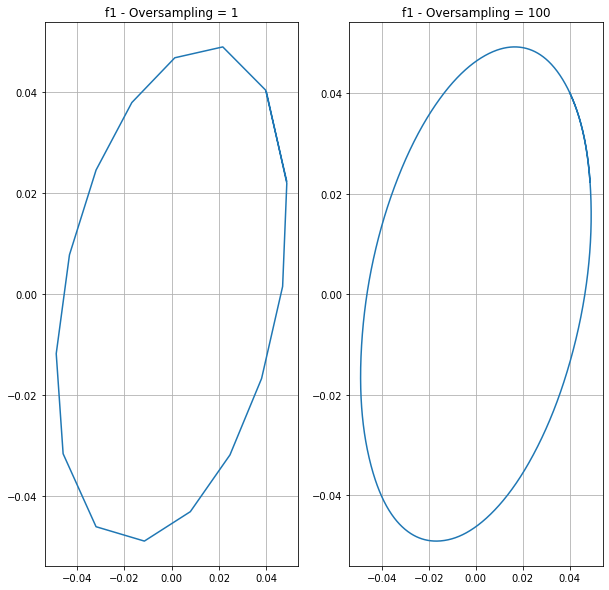

In [32]:
fig = plt.figure()
sans_os = plt.subplot(1,2,1)
sans_os.set_title('f1 - Oversampling = 1')
avec_os = plt.subplot(1,2,2)
avec_os.set_title('f1 - Oversampling = 100')

T = level_curve(f1,0.04,0.04,delta=0.02)
sans_os.grid(True)
sans_os.plot(T[0],T[1])

T = level_curve(f1,0.04,0.04,delta=0.02,oversampling=100)
avec_os.grid(True)
avec_os.plot(T[0],T[1])

plt.show()